In [1]:
import torch
import numpy as np
#from inference_v4 import predict_from_checkpoint
from inference import predict_from_checkpoint
from finpak.data.fetchers.yahoo import download_multiple_tickers
from preprocessing import combine_price_series

from configs import all_configs
from ticker_configs import val_tickers_v9

In [2]:
start_date = '1990-01-01'
end_date = '2024-11-27'

val_tickers_v9 = [
    'DIA', 'SPY', 'QQQ'
]

# Download historical data for the tickers
#data_df = download_multiple_tickers(val_tickers_v3, start_date, end_date)
data_df = download_multiple_tickers(val_tickers_v9, start_date, end_date)
data_df = data_df.loc[:,'Adj Close'] # Extract from multi-index dataframe


# Extract price series for all tickers and convert to tensors
price_series_list = []
for ticker in val_tickers_v9:
    prices = data_df[ticker]
    price_tensor = torch.tensor(prices.to_numpy(), dtype=torch.float32)
    price_series_list.append(price_tensor)

# Combine price series
combined_prices = combine_price_series(price_series_list)

[*********************100%***********************]  3 of 3 completed


In [3]:
data_df.tail()

Ticker,DIA,QQQ,SPY
Date,,,
2024-11-20,434.290009,503.170013,590.500000
2024-11-21,438.970001,504.980011,593.669983
2024-11-22,443.160004,505.790009,595.510010
2024-11-25,447.559998,506.589996,597.530029
2024-11-26,448.880005,509.309998,600.650024


In [4]:
all_configs.keys()

dict_keys(['vMS0001', 'vMS0002', 'vMS0003', 'vMS0003a', 'vMS0003b', 'vMS0003c', 'vMS0003d', 'vMS0004a', 'vMS0004b', 'test_fourier', 'v0', 'v000', 'v001', 'v002', 'v003', 'v004', 'v005', 'v005a', 'v006', 'v007', 'v008', 'v1', 'v1a', 'v1b', 'v2', 'vMP001a', 'vMP002a', 'vMP003a', 'vMP003b', 'vMP003c', 'vMP003d', 'vMP003e', 'vMP003h', 'vMP003hcat', 'vMP003hcatout', 'vMP004a', 'vMP005a', 'vMP006a', 'vMP007a', 'vMP008a', 'vMP009a', 'vMP009h'])

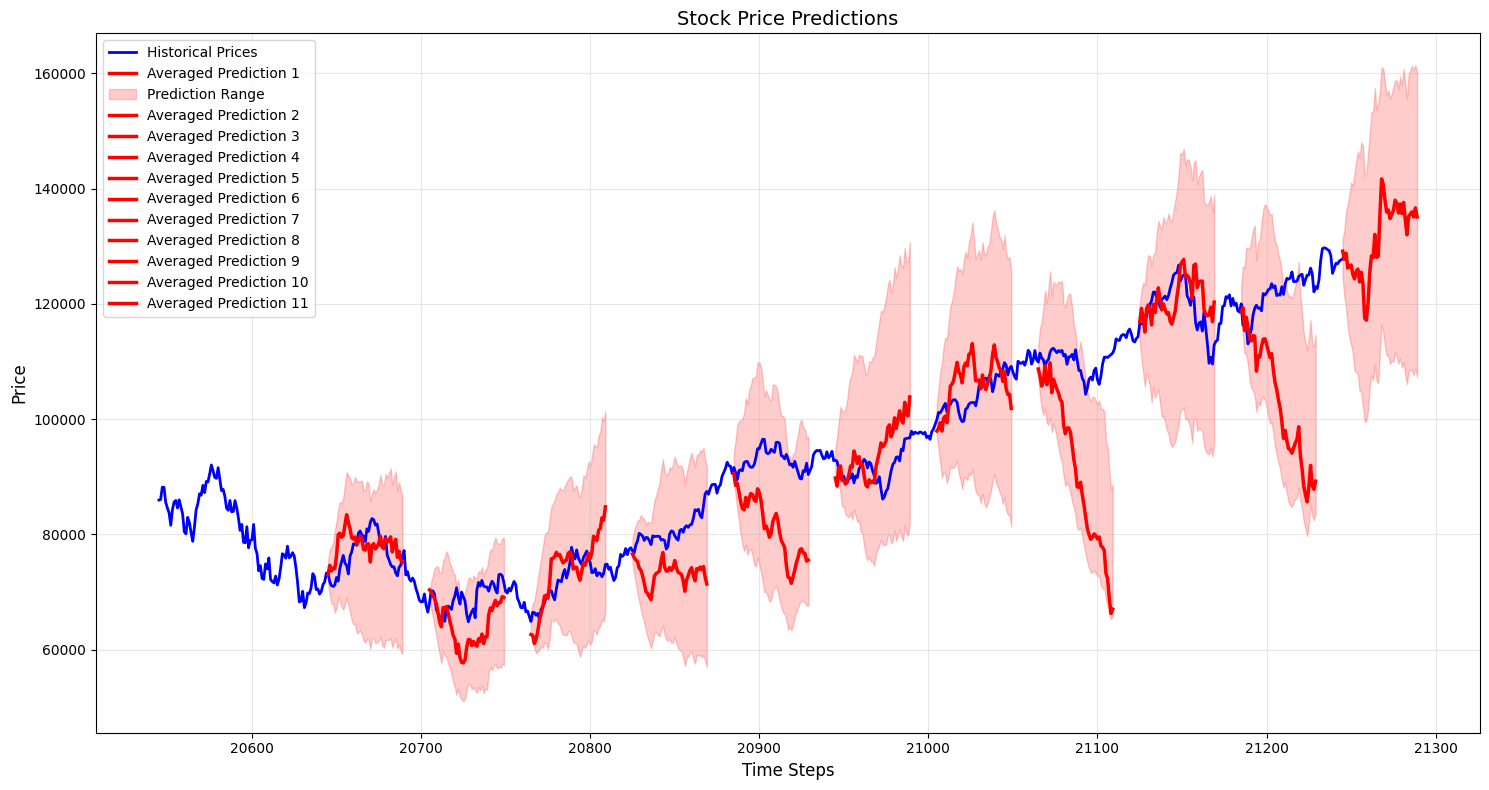

Using checkpoint:  checkpoints/vMP009a_id_0_arc_v3_tc11_vc5_e1710_valloss_0.0013949.pt


In [11]:
# ============= User-Configurable Parameters =============
# Model Selection
CONFIG_NAME = 'vMP009a'
CHECKPOINT_PATH = 'checkpoints/vMP009a_id_0_arc_v3_tc11_vc5_e1710_valloss_0.0013949.pt' # v3
# CHECKPOINT_PATH = 'checkpoints/vMP009h_id_0_arc_v4_tc6_vc6_e146_valloss_0.0000093.pt' # v4 - not great
# CHECKPOINT_PATH = 'checkpoints/vMP003e_id_0_arc_v3_tc11_vc5_e674_valloss_0.0026478.pt' # doesn't run? takes forever
#  excellent with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01

# RECORD OF GOOD CHECKPOINTS DON"T DELETE
# CHECKPOINT_PATH = 'checkpoints/vMP009a_id_0_arc_v3_tc11_vc5_e1710_valloss_0.0013949.pt' # v3 - the predictions are excellent - work on the bounds tho
# CHECKPOINT_PATH = 'checkpoints/vMP003h_id_0_arc_v3_tc11_vc5_e668_valloss_0.0099780.pt' # v4 - predictions seem excellent - need to work on the bounds tho
# CHECKPOINT_PATH = 'saved_checkpoints/vMP005a_final_id_1_arc_v3_e778_valloss_0.0002237.pt' # # good. stability 0.02, dampening 0.9, ewma 0.65, temp 0.01, return scaling 0.5
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003d_id_0_arc_v3_tc6_vc2_e338_valloss_0.0020710.pt' # excellent with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01# 
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003d_id_0_arc_v3_tc7_vc3_e353_valloss_0.0021448.pt' # excellent with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003c_id_0_arc_v3_tc19_vc8_e411_valloss_0.0024866.pt' # good with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003c_id_0_arc_v3_tc20_vc9_e425_valloss_0.0053009.pt' # good with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003b_id_1_arc_v3_tc9_vc7_e441_valloss_0.0005869.pt' # seems good with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003b_id_0_arc_v3_tc7_vc6_e326_valloss_0.0003369.pt' # excellent with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt' # input features only 10?
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003b_id_0_arc_v3_tc4_vc3_e252_valloss_0.0021478.pt' # ok with multihorizon

# Prediction Parameters
N_FUTURE_STEPS = 45
USE_SAMPLING = True
TEMPERATURE = 0.3 # 0.1  # Controls prediction randomness (higher = more random)

# Stability Parameters
STABILITY_THRESHOLD = 0.02 # 0.015  # Max allowed daily return (decrease for more stability)
DAMPENING_FACTOR = 0.95  #   0.65    # Price dampening (decrease for more stability)
EWMA_ALPHA = 0.85 # 0.2          # Price smoothing (decrease for more stability)
RETURN_SCALING_POWER = 0.75 # 1 # Increase to scale down longer term returns more and decrease to increase their impact

# Uncertainty Parameters - higher uncertainty = wider cones
BASE_UNCERTAINTY = 0.0001 # 0.0005 # Initial uncertainty level (as fraction)
UNCERTAINTY_GROWTH = 0.00001 # 0.00025 # Rate at which uncertainty grows per step (as fraction)
MAX_UNCERTAINTY_SINGLE = 0.09 # 0.1 # Maximum bounds for single horizon (±20%)
MAX_UNCERTAINTY_MULTI = 0.16 # 0.25 # Maximum bounds for multi horizon (±50%)
UNCERTAINTY_DAMPING = 0.9 # 0.05 # Dampening factor for uncertainty growth - higher is more dampening = narrower cones

# Multi-horizon Parameters
USE_MULTI_HORIZON = True # False # Ideally set to True
HORIZON_WEIGHTS = None     # Optional: e.g. [0.5, 0.5] to weight different prediction horizons

# Teacher Forcing Parameters
USE_FORCING = False
FORCING_HALFLIFE = 3.0

# Index Generation Parameters
TOP_LEVEL_INDICES = np.arange(0, 660, 60).tolist()
OFFSET_STEPS = [-1, -2, -3 -4, -5] # [-5, -10, -15, -20, -25]

# ============= Config-Derived Parameters =============
# Load config
CONFIG = all_configs[CONFIG_NAME]
MODEL_PARAMS = CONFIG['model_params'].copy()
MODEL_PARAMS.pop('dropout', None)  # Remove dropout for inference

# Get sequence and feature parameters from config
sequence_length = CONFIG['data_params']['sequence_length']
return_periods = CONFIG['data_params']['return_periods']
sma_periods = CONFIG['data_params']['sma_periods']
target_periods = CONFIG['data_params']['target_periods']
momentum_periods = CONFIG['data_params']['momentum_periods']

# Calculate input dimension
d_input = 0
d_input += len(return_periods)  # Return features
d_input += len(sma_periods)     # SMA features
if CONFIG['data_params']['use_momentum']:
    d_input += len(CONFIG['data_params']['momentum_periods'])
if CONFIG['data_params']['use_volatility']:
    d_input += len(return_periods)

# Calculate output dimension
n_outputs = len(target_periods)

# Update model parameters
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs

# ============= Index Generation =============
# Calculate required history
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(momentum_periods) if momentum_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Find last valid index
last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Generate valid start indices
start_indices = []
for base_idx in TOP_LEVEL_INDICES:
    for offset in OFFSET_STEPS:
        idx = last_valid_idx - (base_idx + abs(offset))
        if idx >= total_required_history:
            start_indices.append(idx)

averaged_indices = []
for base_idx in TOP_LEVEL_INDICES:
    sub_indices = []
    for offset in OFFSET_STEPS:
        idx = last_valid_idx - (base_idx + abs(offset))
        if idx >= total_required_history:
            sub_indices.append(idx)
    averaged_indices.append(sub_indices)

start_indices = None


# ============= Make Predictions =============
predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices, # combined_prices,
    start_indices=start_indices,
    averaged_indices=averaged_indices,
    n_steps=N_FUTURE_STEPS,
    config=CONFIG,
    model_params=MODEL_PARAMS,
    use_multi_horizon=USE_MULTI_HORIZON,
    stability_threshold=STABILITY_THRESHOLD,  # Max % daily move - decrease for more stability
    dampening_factor=DAMPENING_FACTOR,  # Stronger dampening - decrease for more stability
    ewma_alpha=EWMA_ALPHA,  # More smoothing - decrease for more stability
    horizon_weights=HORIZON_WEIGHTS, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=USE_FORCING,
    forcing_halflife=FORCING_HALFLIFE,
    temperature=TEMPERATURE,
    use_sampling=USE_SAMPLING,
    return_scaling_power=RETURN_SCALING_POWER,
    base_uncertainty=BASE_UNCERTAINTY,
    uncertainty_growth=UNCERTAINTY_GROWTH,
    max_uncertainty_single=MAX_UNCERTAINTY_SINGLE,
    max_uncertainty_multi=MAX_UNCERTAINTY_MULTI,
    uncertainty_damping=UNCERTAINTY_DAMPING,
    debug=False,
)
print("Using checkpoint: ", CHECKPOINT_PATH)

In [6]:
type(combined_prices)

torch.Tensor

In [7]:
typs = [type(x) for x in combined_prices]
print(set(typs))

{<class 'torch.Tensor'>}


In [8]:
torch.where(torch.isnan(combined_prices), torch.zeros_like(combined_prices), combined_prices)

tensor([4.4508e+01, 4.3961e+01, 4.3590e+01,  ..., 1.2764e+05, 1.2784e+05,
        1.2852e+05])

In [9]:
torch.where(torch.isinf(combined_prices), torch.zeros_like(combined_prices), combined_prices)

tensor([4.4508e+01, 4.3961e+01, 4.3590e+01,  ..., 1.2764e+05, 1.2784e+05,
        1.2852e+05])

In [10]:
min(combined_prices), max(combined_prices), combined_prices[:20], combined_prices[-20:]

(tensor(42.6732),
 tensor(129742.8359),
 tensor([44.5077, 43.9606, 43.5900, 43.4841, 43.6605, 44.1724, 44.6841, 44.8430,
         44.7459, 45.7518, 46.1136, 45.8666, 45.8753, 46.3695, 46.1843, 46.9607,
         46.9607, 47.2607, 47.2342, 47.4725]),
 tensor([125261.1094, 122099.1719, 123002.5859, 122644.2500, 124208.8125,
         127582.7188, 129591.4141, 129742.8359, 129667.1328, 129432.4375,
         129265.8906, 128367.5312, 125309.0547, 126179.6562, 127047.7422,
         126974.5625, 127431.3125, 127635.7188, 127837.5938, 128523.9844]))